# deep-learning-project

Use the "Run" button to execute the code.

In [1]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#Identifying malaria cells using deep learning and pytorch

Done through the following steps

1. Pick a dataset
2. Download the dataset
3. Import thed dataset using pytorch
4. Prepare the dataset for training
5. Move the dataset to the GPU
6. Define the neural networks
7. Train the model
8. Make predictions with sample images repetively with different networks and hyperparameters


In [2]:
import jovian

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od


In [5]:
dataset_url= 'https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria'

In [6]:
import os
import shutil
if os.path.exists( './cell-images-for-detecting-malaria'):
  shutil.rmtree( './cell-images-for-detecting-malaria')

In [7]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manavk2004
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


100%|██████████| 675M/675M [00:08<00:00, 88.5MB/s]


 Installing the data of Malaria cells from Kaggle. Requires kaggle username and api key

In [8]:
data_dir='./cell-images-for-detecting-malaria/cell_images'

In [9]:
import os

In [10]:
os.listdir(data_dir)

['Uninfected', 'cell_images', 'Parasitized']

In [11]:
import shutil

shutil.rmtree(data_dir + '/cell_images')

Removing the extra folder of cell images from the data downloaded.

In [12]:
os.listdir(data_dir)

['Uninfected', 'Parasitized']

In [13]:
for cls in os.listdir(data_dir) :
  print(cls, ':', len(os.listdir(data_dir + "/" + cls)))

Uninfected : 13780
Parasitized : 13780


Checking the sample size of the malaria cells from the data, and checking how many are parasitized or uninfected.

In [14]:
from torchvision.datasets import ImageFolder


Using torch vision to import the class image folder

In [15]:
dataset= ImageFolder(data_dir)

In [16]:
len(dataset)

27558

In [17]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=142x148>, 0)

In [18]:
dataset.classes

['Parasitized', 'Uninfected']

Checking the classes in the dataset.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

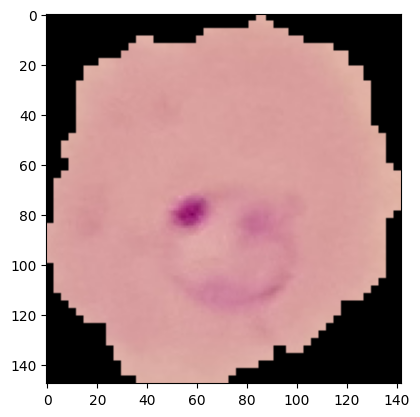

In [20]:
img, label= dataset[0]
plt.imshow(img)

Used matplotlib to graph and look at the images in the dataset before converting to pytorch tensors.

In [21]:

import torchvision.transforms as tt


In [22]:
dataset= ImageFolder(data_dir, tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))

Imported torchvision.transforms to reshape the image ensuring they are all the same size.

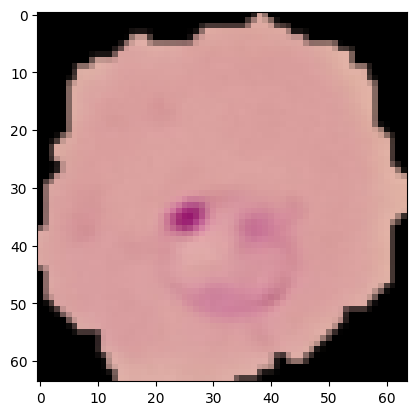

In [23]:
img, label= dataset[0]
plt.imshow(img.permute(1, 2, 0))

In [24]:
val_pct= 0.1
val_size= int(val_pct * len(dataset))
train_size= len(dataset) - val_size
train_size, val_size

(24803, 2755)

Split the images for validation and training.

In [25]:
from torch.utils.data import random_split

train_ds, valid_ds= random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(24803, 2755)

In [26]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                    batch_size*2,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Set the batch size to 128 (due to the pc used) and created training and validation data loaders to load the data into batches.

In [27]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

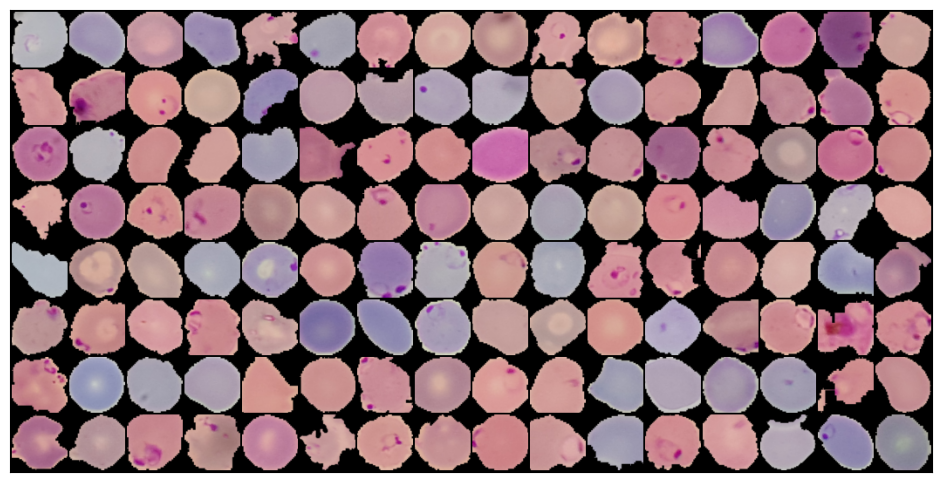

In [28]:
show_batch(train_dl)

Displaying the malaria cells being used in the batch to ensure there are no issues in the dataset.

##GPU Utilities

In [29]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Setting the device to use a Gpu if it is avaliable, if not then the device will use a CPU.

In [30]:
torch.cuda.is_available()

True

In [31]:
device = get_default_device()

In [32]:
device

device(type='cuda')

In [33]:
img, label = dataset[0]

In [34]:
img.shape

torch.Size([3, 64, 64])

In [35]:
img.device


device(type='cpu')

In [36]:
img_gpu= to_device (img, device)
img_gpu.device

device(type='cuda', index=0)

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl= DeviceDataLoader(valid_dl, device)

In [38]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      """calculate loss for a batch of training data"""
      images, labels = batch
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss

    def validation_step(self, batch):
      """calculate loss and accuracy for a batch of validation data"""
      images, labels = batch
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
           epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
  """evaluates the models performance on the validation set"""
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model

In [40]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) #  128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) #  128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), #  128 x 128 x 32 x 32
                                  conv_block(128, 128)) #  128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) #  128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True)#  128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), #  128 x 512 x 8 x 8
                                  conv_block(512, 512)) #  128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), #  128 x 512 x 2 x 2
                                        nn.Flatten(), #  128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [41]:
model= to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [42]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [43]:
torch.cuda.empty_cache()


for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 2])


Emptying the cache to decrease the allocation of memory so the device can run the program.

Training


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
history= [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6934196352958679, 'val_acc': 0.4967712163925171}]

In [46]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4510, val_loss: 0.1548, val_acc: 0.9456
Epoch [1], train_loss: 0.1721, val_loss: 0.1235, val_acc: 0.9491
Epoch [2], train_loss: 0.1570, val_loss: 0.1574, val_acc: 0.9530
Epoch [3], train_loss: 0.1458, val_loss: 0.1254, val_acc: 0.9563
Epoch [4], train_loss: 0.1362, val_loss: 0.1261, val_acc: 0.9563


In [47]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1593, val_loss: 0.1314, val_acc: 0.9501
Epoch [1], train_loss: 0.1457, val_loss: 0.1474, val_acc: 0.9519
Epoch [2], train_loss: 0.1353, val_loss: 0.1530, val_acc: 0.9517
Epoch [3], train_loss: 0.1294, val_loss: 0.1187, val_acc: 0.9572
Epoch [4], train_loss: 0.1207, val_loss: 0.1022, val_acc: 0.9608


Trained the model using 10 epochs, starting from a 48 percent valdiaiton accuracy to approximately a 97 percent validation accuracy after 10 epochs.

In [48]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

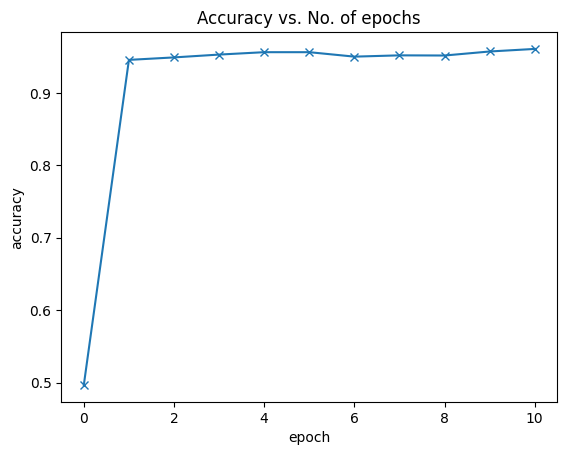

In [49]:
plot_accuracies(history)

In [50]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

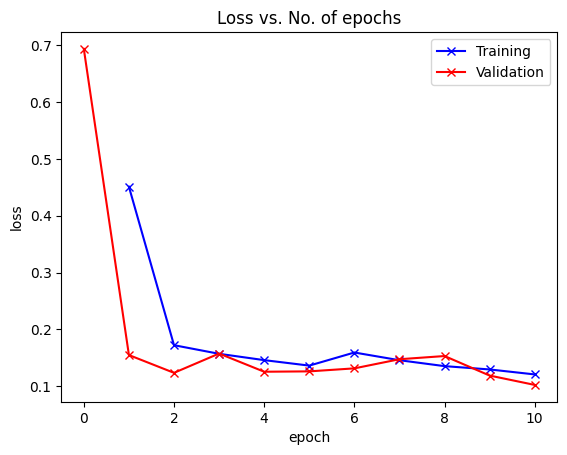

In [51]:
plot_losses(history)

Plotting the training and validaiton loss after 5 epochs to ensure there is no overfitting before moving on to increase the number of epochs.

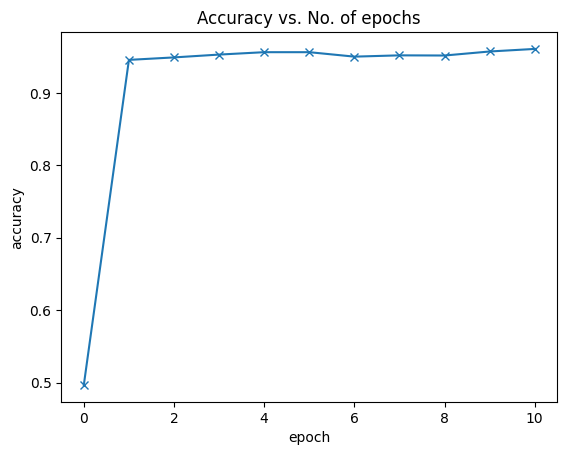

In [52]:
plot_accuracies(history)

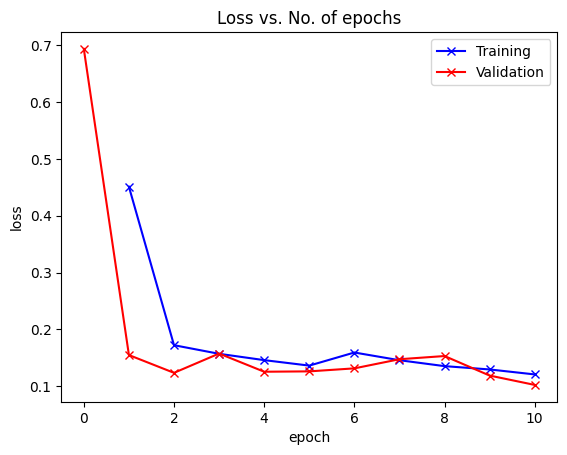

In [53]:
plot_losses(history)

Plotting with 10 epochs to ensure again there is no overfitting

Results

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, arch='ResNet9', epochs= '10', lrs=0.001, opt='Adam')
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········


In [ ]:
jovian.commit(project='deep-learning-project-live')

Test with images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1,2,0)))
  pred= predict_image(img, model, dataset.classes)
  print( 'Target:', dataset.classes[label])
  print('Prediction:', pred)



In [ ]:
show_image_prediction(*valid_ds[42])

In [ ]:
show_image_prediction(*valid_ds[72
                                ])

In [ ]:
show_image_prediction(*valid_ds[25])

In [ ]:
torch.save(model.state_dict(), 'malaria-resnet9.pth')

In [ ]:
show_image_prediction(*valid_ds[43
                                ])

In [ ]:
show_image_prediction(*valid_ds[67
                                ])

Final part of the project, testing to see if the model can predict if the image is parastized with malaria or uninfected, which the model does accurately 3 times in a row meaning it was successful.

In [ ]:
jovian.commit(project='deep-learning-project-live',
              outputs=['malaria-resnet9.pth'])